In [1]:
from __future__ import print_function
import os
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from subprocess import Popen,PIPE,STDOUT,call

In [2]:
from IPython.core.pylabtools import figsize
figsize(20, 10)

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('results.csv')
df.head()

,Trial-ID,Status,Iteration,P,alg,batch_norm,batch_size,data,data_dir,dropout,...,sch,Objective,loss,mean_squared_error,val_loss,val_mean_squared_error,val_weak_loss_0,val_weak_loss_1,weak_loss_0,weak_loss_1
0,13,INTERMEDIATE,0,arcus_gpu.p,random,0,2048,fluxbypass_aqua,/baldig/chemistry/earth_system_science/,0.212090,...,local,224.666601,3.271959e+02,3.271959e+02,224.666601,224.666601,224.666601,993.474719,3.271959e+02,2.595820e+03
1,20,INTERMEDIATE,0,arcus_gpu.p,random,1,2048,fluxbypass_aqua,/baldig/chemistry/earth_system_science/,0.021700,...,local,379.256938,3.927263e+02,3.927263e+02,379.256938,379.256938,379.256938,1057.074468,3.927263e+02,2.550495e+03
2,17,INTERMEDIATE,0,arcus_gpu.p,random,0,2048,fluxbypass_aqua,/baldig/chemistry/earth_system_science/,0.076259,...,local,238.222359,2.714841e+02,2.714841e+02,238.222359,238.222359,238.222359,1504.771366,2.714841e+02,2.566013e+03
3,4,INTERMEDIATE,0,arcus_gpu.p,random,0,2048,fluxbypass_aqua,/baldig/chemistry/earth_system_science/,0.193927,...,local,229.925756,3.447651e+02,3.447651e+02,229.925756,229.925756,229.925756,710.848099,3.447651e+02,2.523445e+03
4,19,INTERMEDIATE,0,arcus_gpu.p,random,0,2048,fluxbypass_aqua,/baldig/chemistry/earth_system_science/,0.165063,...,local,3100.758190,2.117107e+07,2.117107e+07,3100.758190,3100.758190,3100.758190,29331.607310,2.117107e+07,2.668880e+09


# Remove Trials
Trials with a loss above 5,000 are removed

In [5]:
good_df = df.copy(deep=True)
for col in ['weak_loss_0', 'val_weak_loss_0', 'weak_loss_1', 'val_weak_loss_1']:
    bad_ids = good_df[good_df[col] > 5000]['Trial-ID'].unique()
    good_df = good_df[~good_df['Trial-ID'].isin(bad_ids)]

print ('Trials', len(good_df['Trial-ID'].unique()))

Trials 269


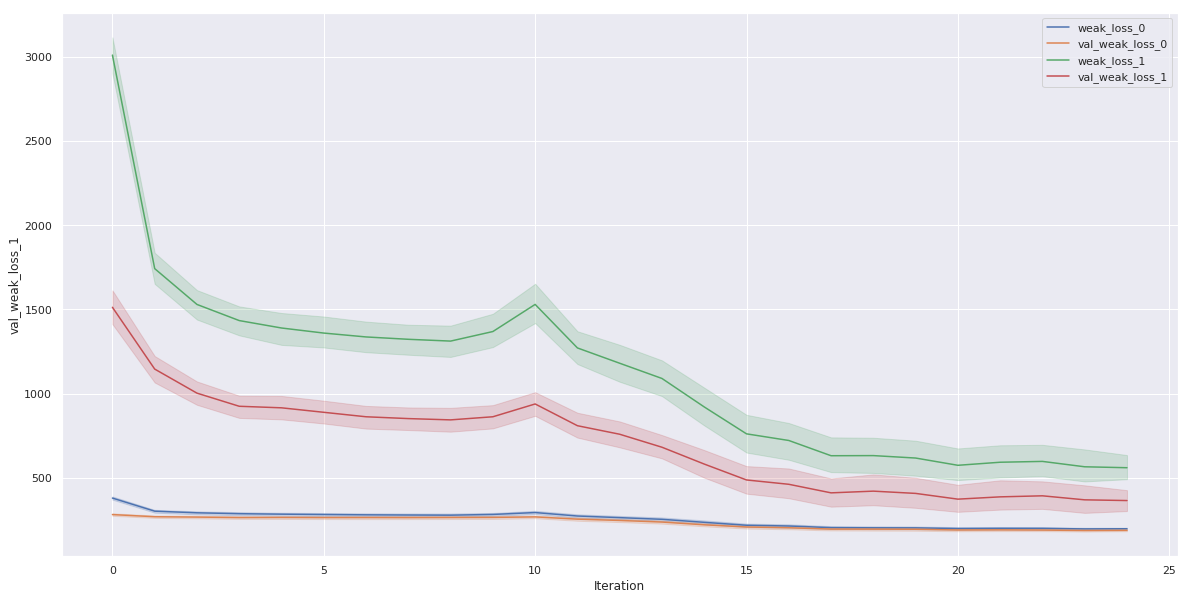

In [6]:
for loss in ['weak_loss_0', 'val_weak_loss_0', 'weak_loss_1', 'val_weak_loss_1']:
    sns.lineplot(x='Iteration', y=loss, data=good_df,label=loss)
    
plt.legend(); plt.show()

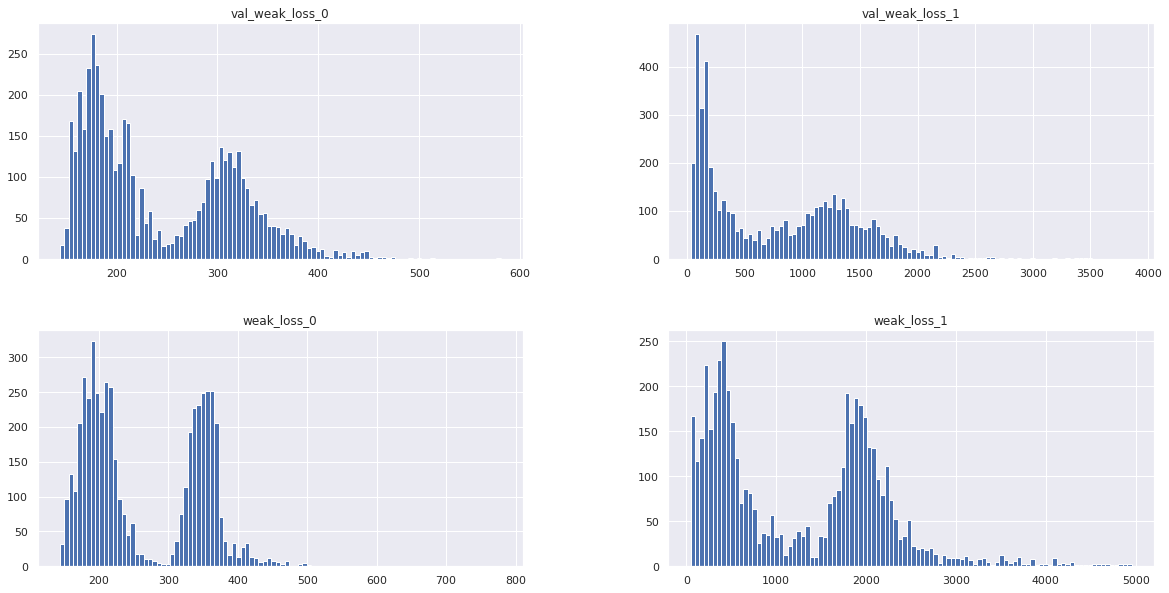

In [7]:
good_df[['weak_loss_0', 'val_weak_loss_0', 'weak_loss_1', 'val_weak_loss_1']].hist(bins=100); plt.show()

# Best Model

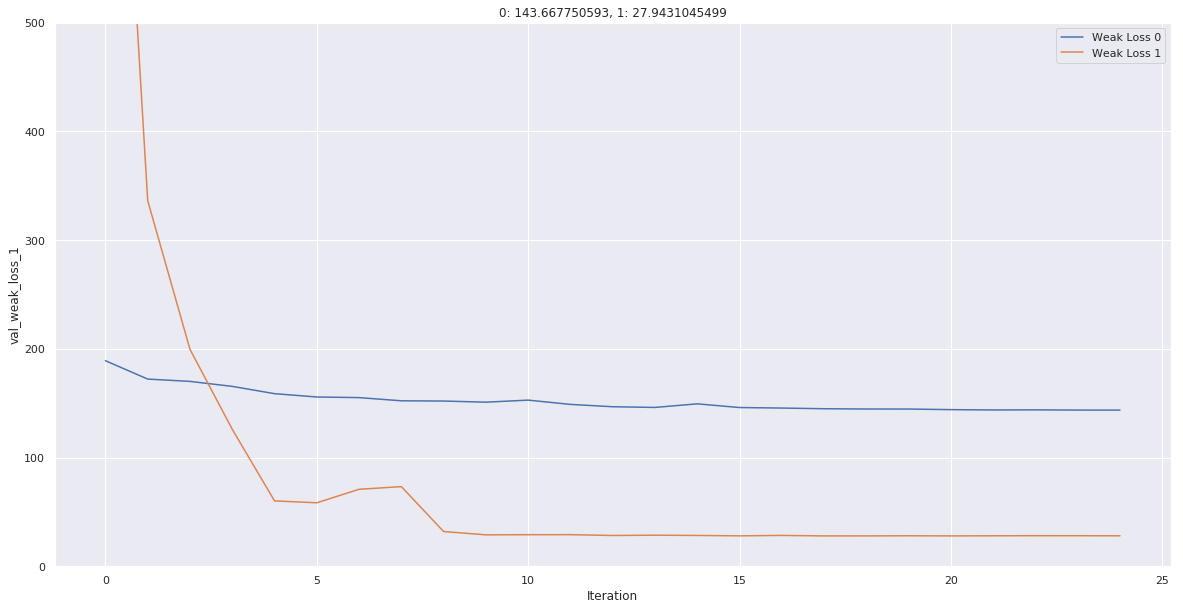

In [8]:
best_0_id = df.iloc[df['val_weak_loss_0'].idxmin()]['Trial-ID']
best_1_id = df.iloc[df['val_weak_loss_1'].idxmin()]['Trial-ID']

sns.lineplot(x='Iteration', y='val_weak_loss_0', data=df[df['Trial-ID'] == best_0_id],label='Weak Loss 0')    
sns.lineplot(x='Iteration', y='val_weak_loss_1', data=df[df['Trial-ID'] == best_1_id],label='Weak Loss 1')   

plt.title('0: {}, 1: {}'.format(df['val_weak_loss_0'].min(), df['val_weak_loss_1'].min()))
plt.ylim(0, 500); plt.legend(); plt.show()

In [9]:
from __future__ import print_function

def hp(loss):
    for item in ['num_layers','dropout','batch_norm','leaky_relu','lr','lr_decay','weak_loss_0', 'val_weak_loss_0', 'weak_loss_1', 'val_weak_loss_1']:
        print(item + ':', df.iloc[df[loss].idxmin()][item])
    print('Layers: ', end='')
    for i in range(df.iloc[df[loss].idxmin()]['num_layers']):
        print(df.iloc[df[loss].idxmin()]['layer_%d' % i], end='  ')

In [10]:
hp('val_weak_loss_1')

num_layers: 3
dropout: 0.028475935238542003
batch_norm: 0
leaky_relu: 0.3672112867627073
lr: 0.00885889718804845
lr_decay: 0.6974788226697946
weak_loss_0: 159.05981970801432
val_weak_loss_0: 154.22048534548568
weak_loss_1: 68.08087292670835
val_weak_loss_1: 27.943104549931263
Layers: 632  401  668  

In [11]:
hp('val_weak_loss_0')

num_layers: 5
dropout: 0.009752514609087104
batch_norm: 0
leaky_relu: 0.2537323330188037
lr: 0.0009767568492833386
lr_decay: 0.8386531344145574
weak_loss_0: 143.56400006915004
val_weak_loss_0: 143.6677505934736
weak_loss_1: 56.67704841068154
val_weak_loss_1: 35.37590530623047
Layers: 625  517  543  538  692  

# Large Difference between WeakLoss 0 and WeakLoss 1

In [12]:
good_df.reset_index(inplace=True)

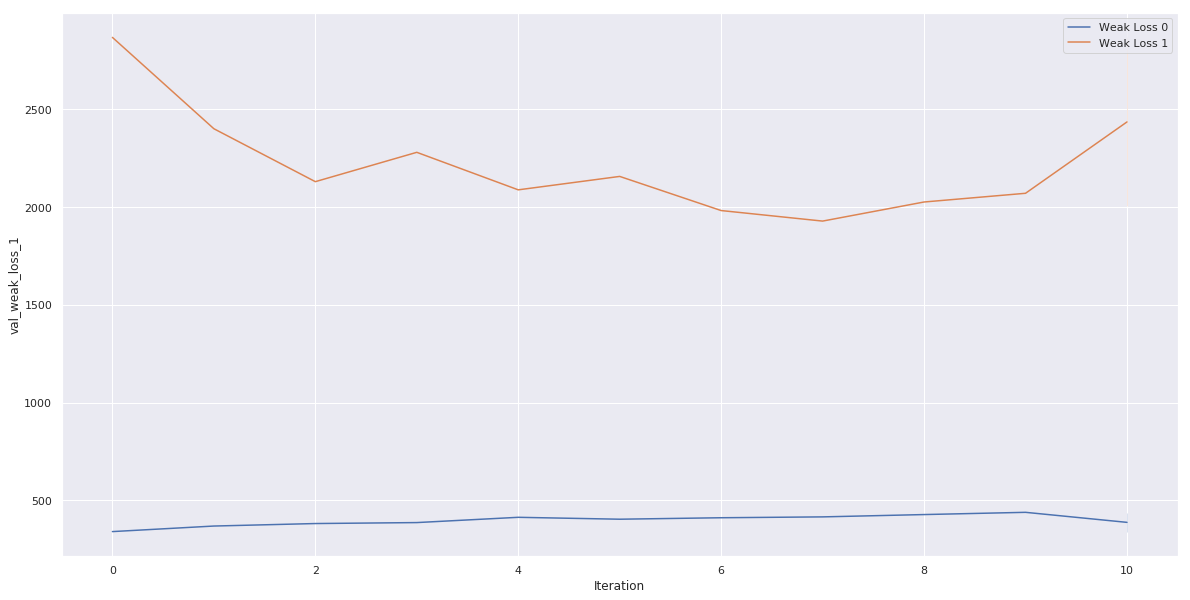

In [13]:
loss_diff = good_df[good_df['Iteration'] > 5]['val_weak_loss_0'] - good_df[good_df['Iteration'] > 5]['val_weak_loss_1']
ID = good_df.iloc[loss_diff.abs().idxmax()]['Trial-ID']

sns.lineplot(x='Iteration', y='val_weak_loss_0', data=df[df['Trial-ID'] == ID],label='Weak Loss 0')   
sns.lineplot(x='Iteration', y='val_weak_loss_1', data=df[df['Trial-ID'] == ID],label='Weak Loss 1')   

plt.legend(); plt.show()

In [14]:
params = df[df['Trial-ID'] == ID].min()

for item in ['num_layers','dropout','batch_norm','leaky_relu','lr','lr_decay','weak_loss_0', 'val_weak_loss_0', 'weak_loss_1', 'val_weak_loss_1']:
    print(item + ':', params[item])
    
print('Layers: ', end='')
for i in range(params['num_layers']):
    print(params['layer_%d' % i], end='  ')

num_layers: 7
dropout: 0.246414770828
batch_norm: 1
leaky_relu: 0.00762347169956
lr: 0.000641145008699
lr_decay: 0.835764856588
weak_loss_0: 363.741517735
val_weak_loss_0: 339.725887827
weak_loss_1: 2419.80318512
val_weak_loss_1: 1928.75518806
Layers: 328  558  680  387  648  518  538  